In [65]:
import torch
import torch.nn as nn
import numpy as np
import pandas as pd
import string, sys
from scipy.spatial.distance import cdist, pdist, squareform
from matplotlib import pyplot as plt

stem_begin, stem_end = '⋊', '⋉'
syms = ['ε',stem_begin,] + [x for x in string.ascii_lowercase] + [stem_end,]

main_dir = '/Users/colin/Desktop/encoder_decoder_outputs/'
params = torch.load(main_dir +'encoder_decoder_params.pt')
stem_ids = torch.load(main_dir +'stem_ids.pt')
stem_encs = torch.load(main_dir +'stem_encs.pt')
dec_states = torch.load(main_dir +'dec_states.pt')
dec_attns = torch.load(main_dir +'dec_attns.pt')

print ('stem_ids:', stem_ids.shape)
print ('stem_encs:', stem_encs.shape)
print ('dec_states:', dec_states.shape)
print ('dec_attns:', dec_attns.shape)
print ('done')

stem_ids: torch.Size([9, 451, 1])
stem_encs: torch.Size([9, 451, 100])
dec_states: torch.Size([12, 451, 100])
dec_attns: torch.Size([12, 451, 9])
done


In [66]:
# list model parameters
for param_tensor in params:
    print(param_tensor, "\t", params[param_tensor].size())

embedding.embedding.weight 	 torch.Size([29, 29])
encoder.embeddings.embedding.weight 	 torch.Size([29, 29])
encoder.rnn.weight_ih_l0 	 torch.Size([150, 29])
encoder.rnn.weight_hh_l0 	 torch.Size([150, 50])
encoder.rnn.bias_ih_l0 	 torch.Size([150])
encoder.rnn.bias_hh_l0 	 torch.Size([150])
encoder.rnn.weight_ih_l0_reverse 	 torch.Size([150, 29])
encoder.rnn.weight_hh_l0_reverse 	 torch.Size([150, 50])
encoder.rnn.bias_ih_l0_reverse 	 torch.Size([150])
encoder.rnn.bias_hh_l0_reverse 	 torch.Size([150])
decoder.embedding.embedding.weight 	 torch.Size([29, 29])
decoder.Ws.weight 	 torch.Size([100, 100])
decoder.Ws.bias 	 torch.Size([100])
decoder.Wz.weight 	 torch.Size([100, 229])
decoder.Wz.bias 	 torch.Size([100])
decoder.Wr.weight 	 torch.Size([100, 229])
decoder.Wr.bias 	 torch.Size([100])
decoder.Wp.weight 	 torch.Size([100, 229])
decoder.Wp.bias 	 torch.Size([100])
decoder.Wa.weight 	 torch.Size([100, 200])
decoder.Wa.bias 	 torch.Size([100])
decoder.va.weight 	 torch.Size([1, 100

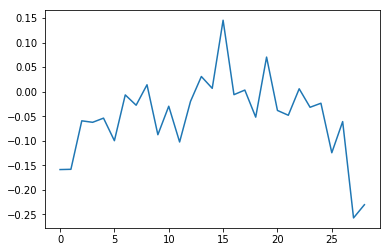

   sym      bias
15   n  0.145658
19   r  0.070505
13   l  0.030927
8    g  0.014066
14   m  0.006825
22   u  0.005874
17   p  0.003255
16   o -0.006100
6    e -0.006618
12   k -0.019926
24   w -0.023584
7    f -0.027626
10   i -0.029692
23   v -0.031840
20   s -0.038285
21   t -0.048107
18   q -0.051948
4    c -0.053972
2    a -0.059454
26   y -0.061028
3    b -0.062484
9    h -0.087785
5    d -0.099981
11   j -0.102603
25   x -0.124560
1    ⋊ -0.158326
0    ε -0.158854
28   ⋉ -0.230539
27   z -0.257459


In [67]:
# inspect generator parameters
plt.plot(params['generator.0.bias'].data.numpy())
plt.show()

dat = pd.DataFrame({
    'sym':syms,
    'bias':params['generator.0.bias'].data.numpy()
})
dat = dat.sort_values('bias', ascending=False)
print (dat)

#plt.matshow(params['generator.0.weight'].data.numpy())
#plt.show()

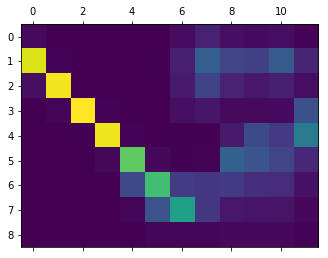

In [68]:
# attention distribution for one example
# (rows: stem positions, columns: output positions)
plt.matshow(dec_attns[:,1,:].data.numpy().T)
plt.show()

[0.001 0.001 0.001 0.001 0.001 0.992 0.001 0.001 0.001 0.001]


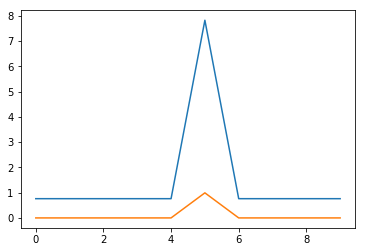

In [69]:
# position-based attention distribution -- hypothetical
v = np.ones(10).T
Wa_s = np.eye(10)[:,5]
Ua_h = np.eye(10)
e = v @ np.tanh(Wa_s + Ua_h)
plt.plot(e)
alpha = np.exp(e)
alpha /= sum(alpha)
print (np.round(alpha, 3))
plt.plot(alpha)
plt.show()

In [88]:
# # # # # # # # # #
# Functional decomposition of role (ordinal position) representations
# source positions
stem_len, batch_len, hidden_dim = stem_encs.shape

Wa = params['decoder.Wa.weight']
ba = params['decoder.Wa.bias']
va = params['decoder.va.weight']
print (Wa.shape, ba.shape, va.shape)

# note: use identity -tanh(x) = tanh(-x) to flip signs in anticipation of multiplication by abs(va)
def decode_posns(encs, ids, enc_len, Wa, ba):
    # extract (putative) position encoding
    posn_map = nn.Linear(hidden_dim, hidden_dim, bias=False)
    posn_map.weight = nn.Parameter(Wa)
    posns = posn_map(encs)
    posns = torch.sign(va.unsqueeze(1)) * posns
    #posns = torch.abs(va) * posns
    print (posns.shape)

    # position vector similarities
    ids_ = ids.contiguous().view(-1, 1)
    posns_ = posns.contiguous().view(-1, hidden_dim)
    mask = [k for k in range(ids_.shape[0]) if ids_[k,0]==0]
    posn_sims = -squareform(pdist(posns_.data.numpy(), 'euclidean'))
    posn_sims[mask,:] = np.nan
    posn_sims[:,mask] = np.nan
    print (posn_sims.shape)
    plt.matshow(posn_sims)
    plt.show()

    # position vector averages
    posn_groups = []
    posn_mus = []
    for i in range(enc_len):
        mask = [j for j in range(batch_len) if ids[i,j,0]!=0]
        posns_i = posns[i,mask,:]
        posn_mu_i = torch.mean(posns_i, 0, keepdim=True)
        posn_groups.append(posns_i)
        posn_mus.append(posn_mu_i)
    posn_mus = torch.cat(posn_mus, 0).data.numpy()

    # avg within / between differences
    posn_dists = np.zeros((enc_len, enc_len))
    for i in range(enc_len):
        for j in range(i, enc_len):
            dists_ij = cdist(posn_groups[i].data.numpy(), posn_groups[j].data.numpy(), 'euclidean')
            dists_ij = -np.mean(np.tril(dists_ij, -1))
            posn_dists[i,j] = posn_dists[j,i] = dists_ij
    plt.matshow(posn_dists)
    plt.show()
    print (np.round(posn_dists, 3))

    # avg position representations
    plt.plot(posn_mus)
    plt.show()
    # similarities of avg position representations
    posn_mu_sims = -squareform(pdist(posn_mus, 'euclidean'))
    plt.matshow(posn_mu_sims)
    plt.show()
    # similarities of avg position representations
    plt.plot(posn_mu_sims)
    plt.show()
    
    return posn_mus

torch.Size([100, 200]) torch.Size([100]) torch.Size([1, 100])


position representations - stems
torch.Size([9, 451, 100])
(4059, 4059)


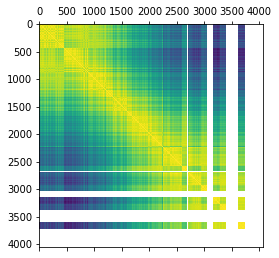

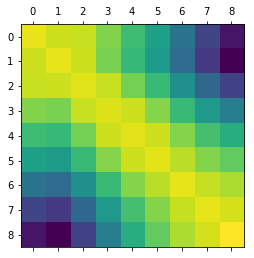

[[ -0.695  -1.546  -1.683  -3.533  -5.659  -7.797 -11.141 -14.248 -16.904]
 [ -1.546  -0.848  -1.515  -3.77   -6.01   -8.227 -11.732 -15.025 -17.943]
 [ -1.683  -1.515  -1.035  -1.699  -3.861  -5.986  -9.05  -11.961 -14.47 ]
 [ -3.533  -3.77   -1.699  -1.118  -1.507  -3.427  -5.943  -8.362 -10.366]
 [ -5.659  -6.01   -3.861  -1.507  -1.004  -1.507  -3.454  -5.382  -6.862]
 [ -7.797  -8.227  -5.986  -3.427  -1.507  -0.929  -1.981  -3.457  -4.458]
 [-11.141 -11.732  -9.05   -5.943  -3.454  -1.981  -0.85   -1.741  -2.388]
 [-14.248 -15.025 -11.961  -8.362  -5.382  -3.457  -1.741  -0.809  -1.287]
 [-16.904 -17.943 -14.47  -10.366  -6.862  -4.458  -2.388  -1.287  -0.176]]


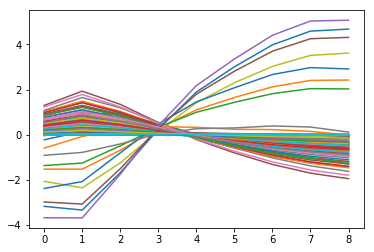

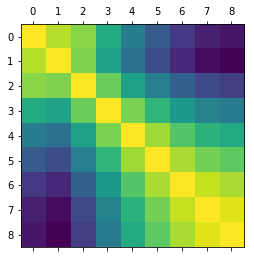

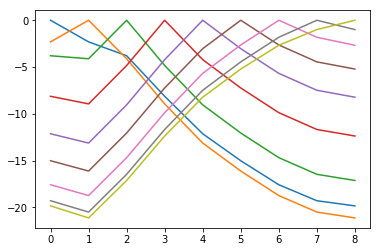

(9, 100) torch.Size([1, 100])
position representations - decoder states
torch.Size([9, 451, 100])
(4059, 4059)


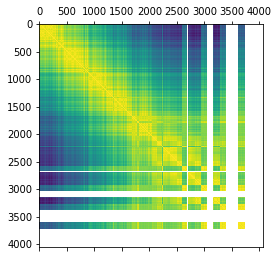

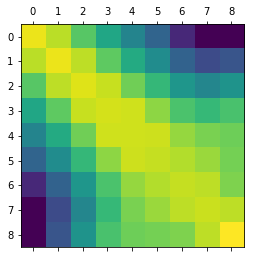

[[ -0.78   -1.943  -4.279  -6.56   -8.687 -10.649 -13.752 -15.525 -15.467]
 [ -1.943  -0.788  -1.843  -4.105  -6.247  -8.123 -10.742 -12.08  -11.551]
 [ -4.279  -1.843  -1.082  -1.613  -3.636  -5.427  -7.567  -8.546  -7.754]
 [ -6.56   -4.105  -1.613  -1.348  -1.459  -2.941  -4.637  -5.364  -4.738]
 [ -8.687  -6.247  -3.636  -1.459  -1.426  -1.538  -2.749  -3.421  -3.693]
 [-10.649  -8.123  -5.427  -2.941  -1.538  -1.673  -2.099  -2.662  -3.54 ]
 [-13.752 -10.742  -7.567  -4.637  -2.749  -2.099  -1.702  -1.843  -3.28 ]
 [-15.525 -12.08   -8.546  -5.364  -3.421  -2.662  -1.843  -1.571  -1.842]
 [-15.467 -11.551  -7.754  -4.738  -3.693  -3.54   -3.28   -1.842  -0.356]]


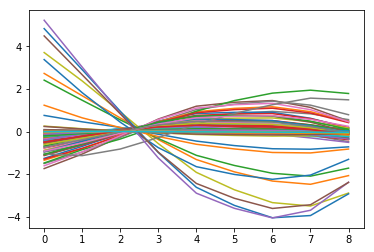

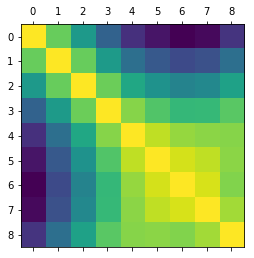

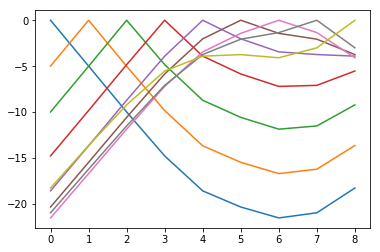

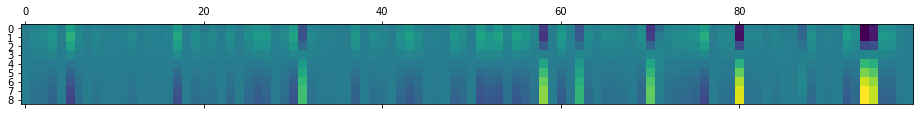

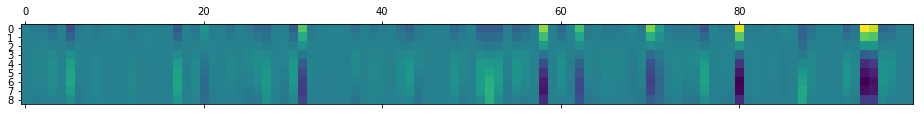

In [89]:
# position representations in stems and decoder states
print ('position representations - stems')
stem_posn_mus = decode_posns(stem_encs, stem_ids, stem_len, Wa[:,hidden_dim:], ba)
print (stem_posn_mus.shape, va.shape)

print ('position representations - decoder states')
dec_posn_mus = decode_posns(dec_states[0:stem_len,:,:], stem_ids, stem_len, Wa[:,0:hidden_dim], ba)

plt.matshow(stem_posn_mus)
plt.matshow(dec_posn_mus)

(9, 100) (9, 100)


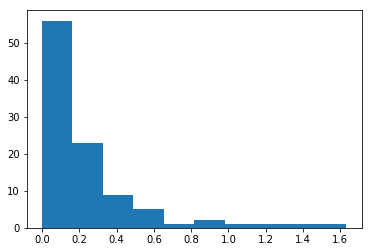

94


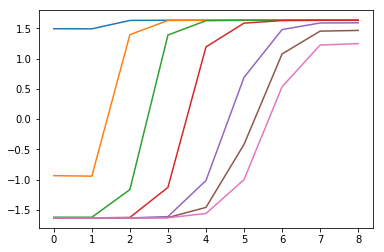

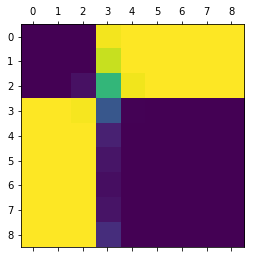

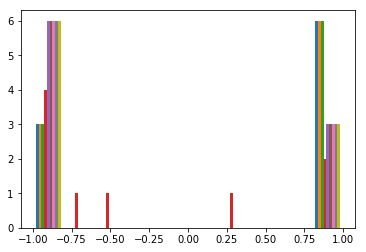

[4.3031683]
[8.426633]
[5.5669794]
[1.6156123]
[-0.9345193]
[-2.341359]
[-3.185378]
[-3.72691]
[-4.114459]


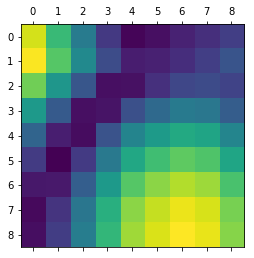

In [73]:
print (stem_posn_mus.shape, dec_posn_mus.shape)
va = torch.abs(va)

plt.hist(va.data.numpy().T)
plt.show()
indx = np.argmax(np.abs(va.data.numpy().T))
print (indx)
#indx = 3

for i in [0,1,2,3,4,5,6]:
    plt.plot(va[0,indx].item() * np.tanh(dec_posn_mus[i,indx] + stem_posn_mus[:,indx]))
plt.show()


x = np.tanh(np.outer(dec_posn_mus[:,indx], stem_posn_mus[:,indx]))
plt.matshow(va[0,indx].item() * x)
#plt.plot(np.tanh(dec_posn_mus[:,indx] + stem_posn_mus[:,indx]))
plt.show()
plt.hist(x)
plt.show()

for i in range(stem_len):
    print (va.data.numpy() @ np.tanh(dec_posn_mus[0,:] + stem_posn_mus[i,:] + ba.data.numpy()))


sims = cdist(stem_posn_mus, dec_posn_mus, 'euclidean')
plt.matshow(sims)
plt.show()

(9, 100) (9, 100)


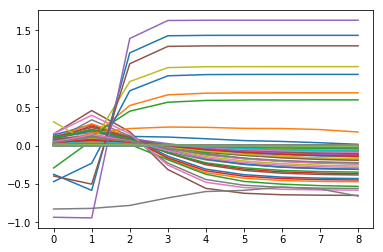

[ 0.  4.  9.  5.  1. -1. -2. -3. -3.]


In [143]:
print (stem_posn_mus.shape, dec_posn_mus.shape)
x = np.abs(va.data.numpy()) * np.tanh(dec_posn_mus[1,:] + stem_posn_mus)
plt.plot(x)
plt.show()
print (np.round(np.sum(x,1),0))

In [184]:
# # # # # # # # # #
# Functional decomposition of identity (character) representations
stem_len, batch_len, hidden_dim = stem_encs.shape

Wo = params['decoder.Wo.weight']
bo = params['decoder.Wo.bias']
print (Wo.shape, bo.shape)

# extract (putative) identity encoding of stem symbols
stem_ident_map = nn.Linear(hidden_dim, hidden_dim, bias=False)
stem_ident_map.weight = nn.Parameter(Wo[:,(29+100):])
stem_idents = stem_ident_map(stem_encs)
stem_idents = stem_idents.contiguous().view(-1, hidden_dim)
print (stem_idents.shape)
stem_ids_ = [x[0] for x in stem_ids.contiguous().view(-1,1).data.numpy()]
print (stem_ids_[0:20])
indx = [x for x in np.argsort(stem_ids_)]
print (indx[0:20])
#print (indx)
stem_ids_ = stem_ids_[indx]
#stem_idents = stem_idents[indx,:]
#plt.matshow(stem_idents.T)
#plt.show()

# identity vector averages
stem_ident_mus = []
for i in range(1, len(syms)):
    mask = [k for k in range(len(stem_ids_)) if stem_ids_[k] == i]
    idents = stem_idents[mask,:]
    ident_mu = torch.mean(idents, 0, keepdim=True)
    stem_ident_mus.append(ident_mu)
stem_ident_mus = torch.cat(stem_ident_mus, 0).data.numpy()
print (stem_ident_mus.shape)
plt.matshow(stem_ident_mus)
plt.show()

# similarities of avg identity representations
ident_mu_sims = 1.0 - squareform(pdist(stem_ident_mus, 'cosine'))
plt.matshow(ident_mu_sims)
plt.show()
plt.hist(ident_mu_sims)
plt.show()

torch.Size([100, 229]) torch.Size([100])
torch.Size([4059, 100])
[1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1]
[4058, 3482, 3481, 3480, 3479, 3478, 3477, 3476, 3475, 3474, 3473, 3472, 3471, 3470, 3469, 3468, 3467, 3466, 3483, 3465]


TypeError: list indices must be integers or slices, not list

In [131]:
# # # # # # # # # #
# Functional decomposition of filler (character) representations
dim = 50
tgt_len = 14
src_batch = 32

linear_out = nn.Linear(dim*2, dim, bias=True)
linear_out.weight = nn.Parameter(
    params['decoder.attn.linear_out.weight'])
linear_out.bias = nn.Parameter(
    params['decoder.attn.linear_out.bias'])

generator = nn.Linear(dim, len(syms), bias=True)
generator.weight = nn.Parameter(
    params['generator.0.weight'])
generator.bias = nn.Parameter(
    params['generator.0.bias'])

inpt = torch.cat([
    input_encodings,
    torch.zeros(input_encodings.shape)], 2)
cc = linear_out(inpt.contiguous().view(-1,dim*2))
print (cc.shape)
#cc = cc.view(tgt_len, src_batch, dim)
pred = generator(cc)
print (pred.shape)

#plt.imshow(cc[:,1,:].data.numpy())
#print (cc[0,0,:])
#print (cc.shape)

# group by input symbol
#print (input_symbols.shape)
sym_vecs = pred
sym_indx = input_symbols.contiguous().view(-1,1)
print (sym_vecs.shape)
print (sym_indx.shape)

sym_indx_ = []
for i in range(1,len(syms)):
    sym_indx_ += [k for k in range(sym_vecs.shape[0]) if sym_indx[k,0]==i]
#plt.plot(sym_vecs[sym_indx_[0:10],:].data.numpy())
#plt.show()
sym_sim = 1-squareform(pdist(sym_vecs[sym_indx_,:].data.numpy(), 'cosine'))
plt.imshow(sym_sim)
plt.show()

sym_vec_mus = []
for i in range(1,len(syms)):
    indx = [k for k in range(sym_vecs.shape[0]) if sym_indx[k,0]==i]
    sym_vec_mus.append(
        torch.mean(sym_vecs[indx,:], 0, keepdim=True)
    )
sym_vec_mus = torch.cat(sym_vec_mus, 0)
plt.imshow(sym_vec_mus.data.numpy())
plt.show()

#plt.plot(sym_vec_mus.data.numpy().T)
#plt.show()

plt.imshow(params['decoder.embeddings.F.weight'].data.numpy())
plt.show()

sym_sim_mus = 1-squareform(pdist(sym_vec_mus.data.numpy(), 'cosine'))
plt.matshow(sym_sim_mus)

KeyError: 'decoder.attn.linear_out.weight'